In [57]:
#import all math libraries
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
from matplotlib import cm  
from sklearn import linear_model
from sklearn import decomposition 

In [58]:
#read dihedral angles data
rama=np.loadtxt('rama_all.xvg')
print(rama[0:10])
print("shape of rama",np.shape(rama))

[[-135.888  -160.113 ]
 [-150.233   -99.0128]
 [ -70.0808  -11.9132]
 [ -57.4871  -14.104 ]
 [-129.121     7.0965]
 [ -82.5249  -24.4214]
 [-157.505   157.605 ]
 [-170.82    158.903 ]
 [-120.77    157.24  ]
 [-101.605  -174.711 ]]
shape of rama (1000000, 2)


In [59]:
#calculate sine and cosine of backbone dihedral angles Phi and Psi
feature=np.zeros([int(len(rama)/10),40])
for i in range(len(feature)):   
    for j in range(10):
        feature[i][j*4+0]=np.sin(rama[i*10+j][0]/180*np.pi)
        feature[i][j*4+1]=np.sin(rama[i*10+j][1]/180*np.pi)
        feature[i][j*4+2]=np.cos(rama[i*10+j][0]/180*np.pi)
        feature[i][j*4+3]=np.cos(rama[i*10+j][1]/180*np.pi)
print("shape of feature",np.shape(feature))

shape of feature (100000, 40)


In [60]:
#normalization
feature_norm=np.zeros([int(len(rama)/10),40]) 
for i in range(40):
    ave=np.mean(feature[:,i]) 
    std=np.std(feature[:,i],ddof=1)
    feature_norm[:,i]=(feature[:,i]-ave)/std

In [61]:
#read potential energy data
energy=np.loadtxt('Scale_all.xvg')   
print(energy[0:10])   
print("shape of energy",np.shape(energy))   

[[ 1.00000000e+00 -1.47027109e+05]
 [ 2.00000000e+00 -1.47431031e+05]
 [ 3.00000000e+00 -1.48044359e+05]
 [ 4.00000000e+00 -1.47358062e+05]
 [ 5.00000000e+00 -1.47179625e+05]
 [ 6.00000000e+00 -1.47591656e+05]
 [ 7.00000000e+00 -1.47060844e+05]
 [ 8.00000000e+00 -1.47151953e+05]
 [ 9.00000000e+00 -1.47441766e+05]
 [ 1.00000000e+01 -1.47800828e+05]]
shape of energy (100000, 2)


In [62]:
#define a function of  FFT and reverse FFT for noise reduction
def FFT(signal,cutoff):
    Y=[]   
    for i in range(1,len(signal)):
        Y.append(signal[len(signal)-i])
    Y.append(signal[0])
    for i in range(len(signal)):
        Y.append(signal[i])
    
    comp_arr = nf.fft(Y)   
    for i in range(len(comp_arr)):
        if i >cutoff and i < len(comp_arr)-cutoff:   
            comp_arr[i] = 0   
    Y2 = nf.ifft(comp_arr).real   
    y2=Y2[int(len(Y)/2):]   
    return y2

In [63]:
#calculate multiple correlation coefficient
def R(x,y):
    model=linear_model.LinearRegression()
    model.fit(x,y)  
    q=sum( (y-model.predict(x))**2 )   
    y_ave=np.mean(y)
    t=sum( (y-y_ave)**2 )   
    r=np.sqrt(1-q/t)   
    return r

In [64]:
#optimize frequency cutoff by multiple correlation coefficient
rr=[]
for cutoff in range(1,500):
    rr.append(    R( feature_norm,FFT(energy[:,1],cutoff) )     )

Best cutoff 9


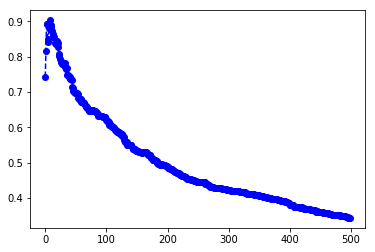

In [65]:
#find the optimize frequency cutoff which is 9, that means first 10 frequencies will be used.
print("Best cutoff",np.argmax(rr)+1)
plt.plot(rr,"bo--")

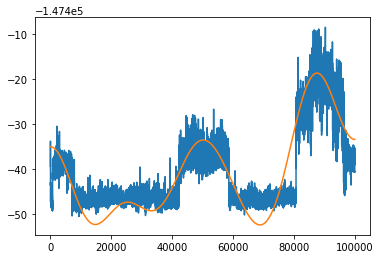

In [66]:
#generate effective energy
model=linear_model.LinearRegression()
model.fit(feature_norm,FFT(energy[:,1],np.argmax(rr)+1))   
plt.plot(model.predict(feature_norm))   #effective energy
plt.plot(FFT(energy[:,1],np.argmax(rr)+1))   #potential energy with noise reduced

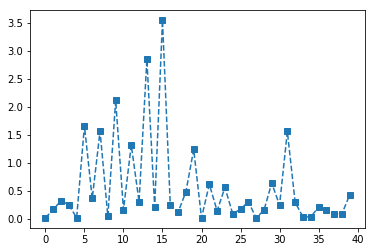

In [67]:
plt.plot(np.abs(model.coef_),"s--")   #回归系数的绝对值，用于后续的重新标度

In [68]:
#rescale all features
feature_norm_rescaled=np.zeros([int(len(rama)/10),40])  
for i in range(40):
    feature_norm_rescaled[:,i]=feature_norm[:,i]*np.abs(model.coef_[i]) 

dimension: 6
shape of feature_mapped (100000, 6)


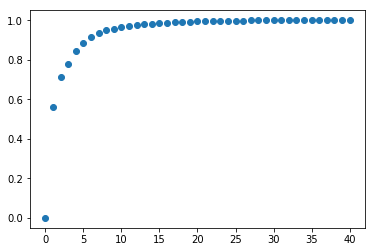

In [69]:
#PCA
pca_test=decomposition.PCA()
pca_test.fit( np.mat(feature_norm_rescaled) ) 

sum_of_eigenvalue=[] 
for i in range(len(pca_test.explained_variance_ratio_)+1):
    sum_of_eigenvalue.append( sum(pca_test.explained_variance_ratio_[:i]) )
    
for i in range(len(sum_of_eigenvalue)):       
    if sum_of_eigenvalue[i] >=0.9:
        n=i
        break

plt.plot(sum_of_eigenvalue,"o")

print("dimension:",n)
pca = decomposition.PCA(n_components=n,copy=True,whiten=False)   
pca.fit( np.mat(feature_norm_rescaled) )   
feature_mapped=pca.transform( np.mat(feature_norm) )  
print("shape of feature_mapped",np.shape(feature_mapped))


In [70]:
# define a function to average the trejectory for reduction of computing resources
def window_ave(x,length):
    m,n=np.shape(x)
    y=np.zeros( [int(m/length),n] )  
    for j in range(n):
        for i in range(int(m/length)):
            y[i,j]=np.mean( np.split(x[:,j],int(m/length))[i] )
    return y

In [76]:
#define a function to calculate the similarity_matrix
def similarity_matrix(data):
    m,n=np.shape(data)
    sum_t1=0
    sum_t2=0
    sum_t1t2=0
    M=np.zeros([m,m])
    for i in range(m):
        for j in range(m):
            for k in range(n):
                sum_t1+=data[i,k]*data[i,k]
                sum_t2+=data[j,k]*data[j,k]
                sum_t1t2+=data[i,k]*data[j,k]
                
            cov_t1t2=(sum_t1t2+1)/np.sqrt((sum_t1+1)*(sum_t2+1));   
            sum_t1=0;
            sum_t2=0;
            sum_t1t2=0;
            M[i,j]=cov_t1t2;
            cov_t1t2=0;
    return M

In [86]:
#average features
feature_mapped_averaged=window_ave(feature_norm,200)
print("shape of feature_mapped_averaged",np.shape(feature_mapped_averaged))

shape of feature_mapped_averaged (500, 40)


In [87]:
#calculate the similarity_matrix
MM=similarity_matrix(feature_mapped_averaged)
print("shape of MM",np.shape(MM))

shape of MM (500, 500)


(500, 500)


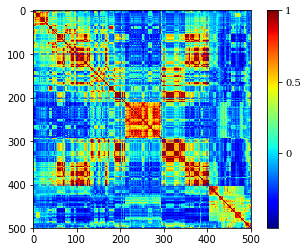

In [88]:
#visualize similarity matrix
print(np.shape(MM))
fig, ax = plt.subplots()
cax = ax.imshow(MM, interpolation='nearest', cmap=cm.jet)
cbar = fig.colorbar(cax, ticks=[0,0.5, 1])
cbar.ax.set_yticklabels(['0','0.5', '1'],fontname='serif')
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=1.5)

In [75]:
MM.min()

-0.14554642086127376

In [89]:
feature_mapped_averaged=window_ave(feature_mapped,200)
print("shape of feature_mapped_averaged",np.shape(feature_mapped_averaged))

shape of feature_mapped_averaged (500, 6)


In [90]:
MM=similarity_matrix(feature_mapped_averaged)
print("shape of MM",np.shape(MM))

shape of MM (500, 500)


(500, 500)


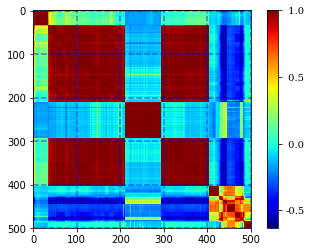

In [92]:
#visualize similarity matrix
print(np.shape(MM))
fig, ax = plt.subplots()
cax = ax.imshow(MM, interpolation='nearest', cmap=cm.jet)
cbar = fig.colorbar(cax, ticks=[-0.5,0,0.5, 1])
cbar.ax.set_yticklabels(['-0.5',' 0.0',' 0.5', ' 1.0'],fontname='serif')
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=1.5)